In [2]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import subprocess
import matplotlib.pyplot as plt
import os
import sys
import nltk
from nltk.translate.bleu_score import corpus_bleu
import pandas as pd

# Download NLTK data (if not already downloaded)
nltk.download('punkt')

# Set random seeds for reproducibility
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



Using device: cuda


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **Data Loading and Preprocessing Functions**

In [3]:
# Data loading function
def load_data(dev_file1, dev_file2, devtest_file1, devtest_file2):
    # Load dev data
    with open(dev_file1, 'r', encoding='utf-8') as f1:
        dev_urdu = [line.strip() for line in f1 if line.strip()]
    with open(dev_file2, 'r', encoding='utf-8') as f2:
        dev_english = [line.strip() for line in f2 if line.strip()]

    # Load devtest data
    with open(devtest_file1, 'r', encoding='utf-8') as f3:
        devtest_urdu = [line.strip() for line in f3 if line.strip()]
    with open(devtest_file2, 'r', encoding='utf-8') as f4:
        devtest_english = [line.strip() for line in f4 if line.strip()]

    # Debugging: Print counts of each file after removing empty lines
    print(f"Loaded {len(dev_urdu)} Urdu sentences from {dev_file1}")
    print(f"Loaded {len(dev_english)} English sentences from {dev_file2}")
    print(f"Loaded {len(devtest_urdu)} Urdu sentences from {devtest_file1}")
    print(f"Loaded {len(devtest_english)} English sentences from {devtest_file2}")

    # Combine data
    urdu_sentences = dev_urdu + devtest_urdu
    english_sentences = dev_english + devtest_english  # Corrected combination

    # Debugging: Print combined counts
    print(f"Total combined Urdu sentences: {len(urdu_sentences)}")
    print(f"Total combined English sentences: {len(english_sentences)}")

    # Ensure equal number of sentences
    if len(urdu_sentences) != len(english_sentences):
        raise ValueError(f"Mismatch in number of Urdu and English sentences. Urdu: {len(urdu_sentences)}, English: {len(english_sentences)}")

    # Pair and shuffle sentences
    data = list(zip(urdu_sentences, english_sentences))
    random.shuffle(data)

    # Unzip the shuffled pairs
    urdu_sentences, english_sentences = zip(*data)

    # Strip any remaining whitespace
    urdu_sentences = [sentence.strip() for sentence in urdu_sentences]
    english_sentences = [sentence.strip() for sentence in english_sentences]

    print(f"After shuffling and stripping, total sentences: {len(urdu_sentences)}")

    if not urdu_sentences or not english_sentences:
        raise ValueError("Loaded sentences are empty after preprocessing. Check the data files.")

    return urdu_sentences, english_sentences

# Tokenization and vocabulary functions
def tokenize_sentences(sentences):
    return [nltk.word_tokenize(sentence) for sentence in sentences]

def build_vocab(tokenized_sentences, min_freq=1):
    vocab = Counter()
    for sentence in tokenized_sentences:
        vocab.update(sentence)
    # Only include words with frequency >= min_freq
    vocab = {word: idx + 4 for idx, (word, count) in enumerate(vocab.items()) if count >= min_freq}
    # Add special tokens
    vocab['<pad>'] = 0
    vocab['<unk>'] = 1
    vocab['<sos>'] = 2
    vocab['<eos>'] = 3
    return vocab

def encode_sequences(tokenized_sentences, word2idx):
    encoded_sequences = []
    for sentence in tokenized_sentences:
        encoded_sentence = [word2idx.get('<sos>')]
        encoded_sentence += [word2idx.get(token, word2idx['<unk>']) for token in sentence]
        encoded_sentence.append(word2idx.get('<eos>'))
        encoded_sequences.append(encoded_sentence)
    return encoded_sequences

def pad_sequences(sequences, max_len, pad_value=0):
    return [seq + [pad_value] * (max_len - len(seq)) for seq in sequences]


# **Define Dataset and DataLoader Classes**

In [4]:
# Dataset class
class TranslationDataset(Dataset):
    def __init__(self, input_sequences, target_sequences):
        self.input_sequences = [torch.tensor(seq, dtype=torch.long) for seq in input_sequences]
        self.target_sequences = [torch.tensor(seq, dtype=torch.long) for seq in target_sequences]

    def __len__(self):
        return len(self.input_sequences)

    def __getitem__(self, idx):
        return self.input_sequences[idx], self.target_sequences[idx]


# **Define Model Components (LSTM Cell, Encoder, Attention, Decoder, Seq2Seq)**

In [ ]:
# Manual LSTMCell implementation with Dropout
class MyLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(MyLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.wx = nn.Linear(input_size, 4 * hidden_size) #wx and wh: Linear transformations for input and hidden states.
        self.wh = nn.Linear(hidden_size, 4 * hidden_size)

        self.dropout = nn.Dropout(dropout)

        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

    def forward(self, x, hx):
        h_prev, c_prev = hx

        gates = self.wx(x) + self.wh(h_prev)
        i_gate, f_gate, g_gate, o_gate = gates.chunk(4, dim=1)

        i_gate = torch.sigmoid(i_gate)
        f_gate = torch.sigmoid(f_gate)
        g_gate = torch.tanh(g_gate)
        o_gate = torch.sigmoid(o_gate)

        c_next = f_gate * c_prev + i_gate * g_gate
        h_next = o_gate * torch.tanh(c_next)
        h_next = self.dropout(h_next)

        return h_next, c_next

# Encoder with Bidirectional LSTM
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.hidden_size = hidden_size
        self.lstm_cell_forward = MyLSTMCell(embedding_size, hidden_size, dropout)
        self.lstm_cell_backward = MyLSTMCell(embedding_size, hidden_size, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)  # (batch_size, seq_len, embedding_size)
        embedded = self.dropout(embedded)
        batch_size, seq_len, _ = embedded.size()

        # Forward LSTM
        h_t_f = torch.zeros(batch_size, self.hidden_size, device=embedded.device)
        c_t_f = torch.zeros(batch_size, self.hidden_size, device=embedded.device)
        outputs_f = []

        for t in range(seq_len):
            h_t_f, c_t_f = self.lstm_cell_forward(embedded[:, t, :], (h_t_f, c_t_f))
            outputs_f.append(h_t_f.unsqueeze(1))

        outputs_f = torch.cat(outputs_f, dim=1)  # (batch_size, seq_len, hidden_size)

        # Backward LSTM
        h_t_b = torch.zeros(batch_size, self.hidden_size, device=embedded.device)
        c_t_b = torch.zeros(batch_size, self.hidden_size, device=embedded.device)
        outputs_b = []

        for t in reversed(range(seq_len)):
            h_t_b, c_t_b = self.lstm_cell_backward(embedded[:, t, :], (h_t_b, c_t_b))
            outputs_b.insert(0, h_t_b.unsqueeze(1))  # Insert at the beginning

        outputs_b = torch.cat(outputs_b, dim=1)  # (batch_size, seq_len, hidden_size)

        # Concatenate forward and backward outputs
        outputs = torch.cat((outputs_f, outputs_b), dim=2)  # (batch_size, seq_len, 2*hidden_size)
        return outputs, (h_t_f, c_t_f), (h_t_b, c_t_b)

# Attention mechanism
class Attention(nn.Module):
    def __init__(self, hidden_size, enc_hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size + enc_hidden_size, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        nn.init.xavier_uniform_(self.attn.weight)
        nn.init.uniform_(self.v, -0.1, 0.1)

    def forward(self, hidden, encoder_outputs, mask):
        # hidden: (batch_size, hidden_size)
        # encoder_outputs: (batch_size, seq_len, enc_hidden_size)
        batch_size, seq_len, enc_hidden_size = encoder_outputs.size()

        # Repeat hidden state seq_len times
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)  # (batch_size, seq_len, hidden_size)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # (batch_size, seq_len, hidden_size)
        energy = energy.permute(0, 2, 1)  # (batch_size, hidden_size, seq_len)
        v = self.v.repeat(batch_size, 1).unsqueeze(1)  # (batch_size, 1, hidden_size)
        attention_weights = torch.bmm(v, energy).squeeze(1)  # (batch_size, seq_len)

        attention_weights = attention_weights.masked_fill(mask == 0, -1e10)
        return torch.softmax(attention_weights, dim=1)  # (batch_size, seq_len)

# Decoder with Attention
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, enc_hidden_size, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.hidden_size = hidden_size
        self.enc_hidden_size = enc_hidden_size
        self.lstm_cell = MyLSTMCell(embedding_size + enc_hidden_size, hidden_size, dropout)
        self.attention = Attention(hidden_size, enc_hidden_size)
        self.fc = nn.Linear(hidden_size + enc_hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_seq, encoder_outputs, hidden, cell, mask):
        # input_seq: (batch_size)
        embedded = self.embedding(input_seq)  # (batch_size, embedding_size)
        embedded = self.dropout(embedded)

        # Calculate attention weights
        attn_weights = self.attention(hidden, encoder_outputs, mask)  # (batch_size, seq_len)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # (batch_size, enc_hidden_size)

        # Combine embedded input and context
        input_combined = torch.cat((embedded, context), dim=1)  # (batch_size, embedding_size + enc_hidden_size)

        # Pass through LSTM cell
        hidden, cell = self.lstm_cell(input_combined, (hidden, cell))  # Both are (batch_size, hidden_size)

        # Output layer
        output = self.fc(torch.cat((hidden, context), dim=1))  # (batch_size, vocab_size)

        return output, hidden, cell, attn_weights

# Seq2Seq model with Corrected Initialization
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, beam_width=1):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.beam_width = beam_width

        # Initialize linear layers for decoder hidden and cell state
        self.fc_hidden = nn.Linear(2 * encoder.hidden_size, decoder.hidden_size).to(device)
        self.fc_cell = nn.Linear(2 * encoder.hidden_size, decoder.hidden_size).to(device)

    def create_mask(self, src):
        # src: (batch_size, src_len)
        mask = (src != 0)
        return mask  # (batch_size, src_len)

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        # source: (batch_size, src_len)
        # target: (batch_size, tgt_len)
        batch_size, tgt_len = target.size()
        vocab_size = self.decoder.fc.out_features

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, tgt_len, vocab_size).to(self.device)

        # Encoder outputs
        encoder_outputs, (hidden_f, c_t_f), (hidden_b, c_t_b) = self.encoder(source)
        # Combine forward and backward hidden states
        hidden = torch.cat((hidden_f, hidden_b), dim=1)  # (batch_size, 2*hidden_size)
        cell = torch.cat((c_t_f, c_t_b), dim=1)        # (batch_size, 2*hidden_size)

        # Initialize decoder hidden and cell state using linear layers
        decoder_hidden = self.fc_hidden(hidden)  # (batch_size, hidden_size)
        decoder_cell = self.fc_cell(cell)        # (batch_size, hidden_size)

        mask = self.create_mask(source)  # (batch_size, src_len)

        # First input to the decoder is the <sos> tokens
        input_seq = target[:, 0]  # (batch_size)

        for t in range(1, tgt_len):
            output, decoder_hidden, decoder_cell, attn_weights = self.decoder(
                input_seq, encoder_outputs, decoder_hidden, decoder_cell, mask
            )
            outputs[:, t, :] = output

            # Decide whether to do teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)  # (batch_size)

            input_seq = target[:, t] if teacher_force else top1

        return outputs

    def translate(self, source, max_len=50):
        # source: (batch_size, src_len)
        self.eval()
        with torch.no_grad():
            batch_size = source.size(0)
            encoder_outputs, (hidden_f, c_t_f), (hidden_b, c_t_b) = self.encoder(source)
            hidden = torch.cat((hidden_f, hidden_b), dim=1)  # (batch_size, 2*hidden_size)
            cell = torch.cat((c_t_f, c_t_b), dim=1)        # (batch_size, 2*hidden_size)

            # Initialize decoder hidden and cell state using linear layers
            decoder_hidden = self.fc_hidden(hidden)  # (batch_size, hidden_size)
            decoder_cell = self.fc_cell(cell)        # (batch_size, hidden_size)

            mask = self.create_mask(source)  # (batch_size, src_len)

            # Initialize input with <sos>
            input_seq = torch.full((batch_size,), english_word2idx['<sos>'], dtype=torch.long, device=self.device)

            translations = [[] for _ in range(batch_size)]

            for _ in range(max_len):
                output, decoder_hidden, decoder_cell, attn_weights = self.decoder(
                    input_seq, encoder_outputs, decoder_hidden, decoder_cell, mask
                )
                top1 = output.argmax(1)  # (batch_size)

                for i in range(batch_size):
                    token = top1[i].item()
                    if token == english_word2idx['<eos>']:
                        continue
                    translations[i].append(token)

                input_seq = top1

            return translations


# **Define Training and Evaluation Functions**

In [ ]:
# Training function without Early Stopping
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device, clip=1.0):
    model.to(device)
    train_losses = []
    val_losses = []
    val_bleu_scores = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0

        for input_seq, target_seq in train_loader:
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)

            optimizer.zero_grad()
            output = model(input_seq, target_seq)

            # Reshape for loss calculation
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)  # Exclude first token
            target = target_seq[:, 1:].reshape(-1)         # Exclude first token

            loss = criterion(output, target)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()

            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        epoch_val_loss = 0

        all_references = []
        all_hypotheses = []

        with torch.no_grad():
            for input_seq, target_seq in val_loader:
                input_seq = input_seq.to(device)
                target_seq = target_seq.to(device)

                output = model(input_seq, target_seq, teacher_forcing_ratio=0)  # No teacher forcing during evaluation

                output_dim = output.shape[-1]
                output = output[:, 1:].reshape(-1, output_dim)
                target = target_seq[:, 1:].reshape(-1)

                loss = criterion(output, target)
                epoch_val_loss += loss.item()

                # Generate translations for BLEU
                predictions = model.translate(input_seq)
                for i in range(len(predictions)):
                    pred_tokens = [english_idx2word.get(idx, '<unk>') for idx in predictions[i]]
                    pred_sentence = ' '.join(pred_tokens)
                    translations = pred_sentence.split()

                    # Reference sentence
                    ref_tokens = [english_idx2word.get(idx.item(), '<unk>') for idx in target_seq[i]]
                    # Remove <eos>, <pad>, etc.
                    ref_tokens = [word for word in ref_tokens if word not in ['<eos>', '<pad>', '<unk>', '<sos>']]
                    all_references.append([ref_tokens])
                    all_hypotheses.append(translations)

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Calculate BLEU score
        val_bleu = corpus_bleu(all_references, all_hypotheses) 
        val_bleu_scores.append(val_bleu)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val BLEU: {val_bleu:.2f}")

    # Save the final model
    torch.save(model.state_dict(), 'final_seq2seq_model.pth')

    return train_losses, val_losses, val_bleu_scores

# Function to compute BLEU score using NLTK's corpus_bleu
def compute_bleu_score(references, hypotheses):
    # references: list of list of reference sentences
    # hypotheses: list of hypothesis sentences
    return corpus_bleu(references, hypotheses) * 100

# Function to generate translations and collect references and hypotheses
def generate_translations_collect(model, data_loader, idx2word):
    model.eval()
    translations = []
    references = []

    with torch.no_grad():
        for input_seq, target_seq in data_loader:
            input_seq = input_seq.to(device)
            predictions = model.translate(input_seq)

            for i in range(len(predictions)):
                # Convert indices to words for the prediction
                pred_tokens = [idx2word.get(idx, '<unk>') for idx in predictions[i]]
                pred_sentence = ' '.join(pred_tokens)
                translations.append(pred_sentence)

                # Convert indices to words for the reference
                ref_tokens = [english_idx2word.get(idx.item(), '<unk>') for idx in target_seq[i]]
                ref_tokens = [word for word in ref_tokens if word not in ['<sos>', '<pad>', '<eos>', '<unk>']]
                ref_sentence = ' '.join(ref_tokens)
                references.append(ref_sentence)

    return references, translations

# Plotting function
def plot_results(train_losses, val_losses, val_bleu_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot BLEU Score
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_bleu_scores, label='Validation BLEU Score', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('BLEU Score')
    plt.title('Validation BLEU Score Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to create a comparative results table
def create_results_table(train_losses, val_losses, val_bleu_scores, test_loss, test_bleu):
    data = {
        'Metric': ['Loss', 'BLEU Score'],
        'Training Set': [train_losses[-1], '-'],
        'Validation Set': [val_losses[-1], val_bleu_scores[-1]],
        'Test Set': [test_loss, test_bleu]
    }
    df = pd.DataFrame(data)
    return df


# **Data Preparation and Splitting**

In [ ]:
nltk.download('punkt_tab')
# Data file paths
dev_file1 = 'urd_Arab.dev'          # Urdu sentences
dev_file2 = 'eng_Latn.dev'          # English sentences
devtest_file1 = 'urd_Arab.devtest'  # Urdu sentences
devtest_file2 = 'eng_Latn.devtest'  # English sentences

# Check if data files exist
for file in [dev_file1, dev_file2, devtest_file1, devtest_file2]:
    if not os.path.exists(file):
        print(f"Data file {file} not found. Please ensure all data files are present in the Colab environment.")
        # Optionally, you can upload files manually in Colab or mount Google Drive
        # from google.colab import files
        # uploaded = files.upload()
        sys.exit(1)

# Load data
urdu_sentences, english_sentences = load_data(dev_file1, dev_file2, devtest_file1, devtest_file2)

# Tokenize sentences
urdu_tokenized = tokenize_sentences(urdu_sentences)
english_tokenized = tokenize_sentences(english_sentences)

# Build vocabularies
urdu_vocab = build_vocab(urdu_tokenized, min_freq=1)
english_vocab = build_vocab(english_tokenized, min_freq=1)

urdu_word2idx = urdu_vocab
english_word2idx = english_vocab

urdu_idx2word = {idx: word for word, idx in urdu_vocab.items()}
english_idx2word = {idx: word for word, idx in english_vocab.items()}

# Encode sequences
urdu_encoded = encode_sequences(urdu_tokenized, urdu_word2idx)
english_encoded = encode_sequences(english_tokenized, english_word2idx)

# Find max sequence lengths
max_urdu_len = max(len(seq) for seq in urdu_encoded)
max_english_len = max(len(seq) for seq in english_encoded)

# Pad sequences
urdu_padded = pad_sequences(urdu_encoded, max_urdu_len, pad_value=urdu_word2idx['<pad>'])
english_padded = pad_sequences(english_encoded, max_english_len, pad_value=english_word2idx['<pad>'])

# Split data into training, validation, and test sets
total_data = list(zip(urdu_padded, english_padded))
random.shuffle(total_data)
total_size = len(total_data)
train_size = int(0.7 * total_size)#70% of the data is used for training
val_size = int(0.15 * total_size)#15% of the data is used for validation

train_data = total_data[:train_size]
val_data = total_data[train_size:train_size + val_size]
test_data = total_data[train_size + val_size:] #15% of the data is used for testing

train_urdu, train_english = zip(*train_data)
val_urdu, val_english = zip(*val_data)
test_urdu, test_english = zip(*test_data)

# Debugging: Print split sizes
print(f"Training set size: {len(train_urdu)}")
print(f"Validation set size: {len(val_urdu)}")
print(f"Test set size: {len(test_urdu)}")

# Create datasets
train_dataset = TranslationDataset(train_urdu, train_english)
val_dataset = TranslationDataset(val_urdu, val_english)
test_dataset = TranslationDataset(test_urdu, test_english)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Loaded 997 Urdu sentences from urd_Arab.dev
Loaded 997 English sentences from eng_Latn.dev
Loaded 1012 Urdu sentences from urd_Arab.devtest
Loaded 1012 English sentences from eng_Latn.devtest
Total combined Urdu sentences: 2009
Total combined English sentences: 2009
After shuffling and stripping, total sentences: 2009
Training set size: 1406
Validation set size: 301
Test set size: 302


# **Initialize and Train the Model**

In [9]:
# Model parameters
input_size = len(urdu_vocab)
output_size = len(english_vocab)
embedding_size = 256
hidden_size = 512  # Increased hidden size for better capacity
enc_hidden_size = 2 * hidden_size  # Correctly set to 1024
num_epochs = 50  # Increased epochs for better training
learning_rate = 0.001
dropout = 0.3  # Increased dropout for better regularization

print(f"Encoder Hidden Size: {enc_hidden_size}")

# Initialize the model
encoder = Encoder(input_size, embedding_size, hidden_size, dropout=dropout)
decoder = Decoder(output_size, embedding_size, hidden_size, enc_hidden_size, dropout=dropout)
model = Seq2Seq(encoder, decoder, device).to(device)

# Verify Decoder's FC Layer
print(f"Decoder FC Layer Input Features: {model.decoder.fc.in_features}")  # Should be (hidden_size + enc_hidden_size)
print(f"Decoder FC Layer Output Features: {model.decoder.fc.out_features}")  # Should be vocab_size

# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=english_word2idx['<pad>'])

# Train the model
train_losses, val_losses, val_bleu_scores = train_model(
    model, train_loader, val_loader, optimizer, criterion, num_epochs, device,
    clip=1.0
)


Encoder Hidden Size: 1024
Decoder FC Layer Input Features: 1536
Decoder FC Layer Output Features: 9417


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch [1/50], Train Loss: 7.4014, Val Loss: 6.9863, Val BLEU: 0.00
Epoch [2/50], Train Loss: 6.6392, Val Loss: 7.0377, Val BLEU: 0.00
Epoch [3/50], Train Loss: 6.3766, Val Loss: 7.1307, Val BLEU: 0.00
Epoch [4/50], Train Loss: 5.9769, Val Loss: 7.2310, Val BLEU: 0.00
Epoch [5/50], Train Loss: 5.3340, Val Loss: 7.3837, Val BLEU: 0.00
Epoch [6/50], Train Loss: 4.6090, Val Loss: 7.5513, Val BLEU: 0.00
Epoch [7/50], Train Loss: 4.0250, Val Loss: 7.7175, Val BLEU: 0.00
Epoch [8/50], Train Loss: 3.7266, Val Loss: 7.8706, Val BLEU: 0.00
Epoch [9/50], Train Loss: 3.5046, Val Loss: 7.9476, Val BLEU: 0.00
Epoch [10/50], Train Loss: 3.3421, Val Loss: 8.0188, Val BLEU: 0.00
Epoch [11/50], Train Loss: 3.1961, Val Loss: 8.0401, Val BLEU: 0.35
Epoch [12/50], Train Loss: 3.0475, Val Loss: 8.0983, Val BLEU: 0.44
Epoch [13/50], Train Loss: 2.9127, Val Loss: 8.1324, Val BLEU: 0.53
Epoch [14/50], Train Loss: 2.8183, Val Loss: 8.2041, Val BLEU: 0.00
Epoch [15/50], Train Loss: 2.6992, Val Loss: 8.1971, Val 

# **Plot Training Results**

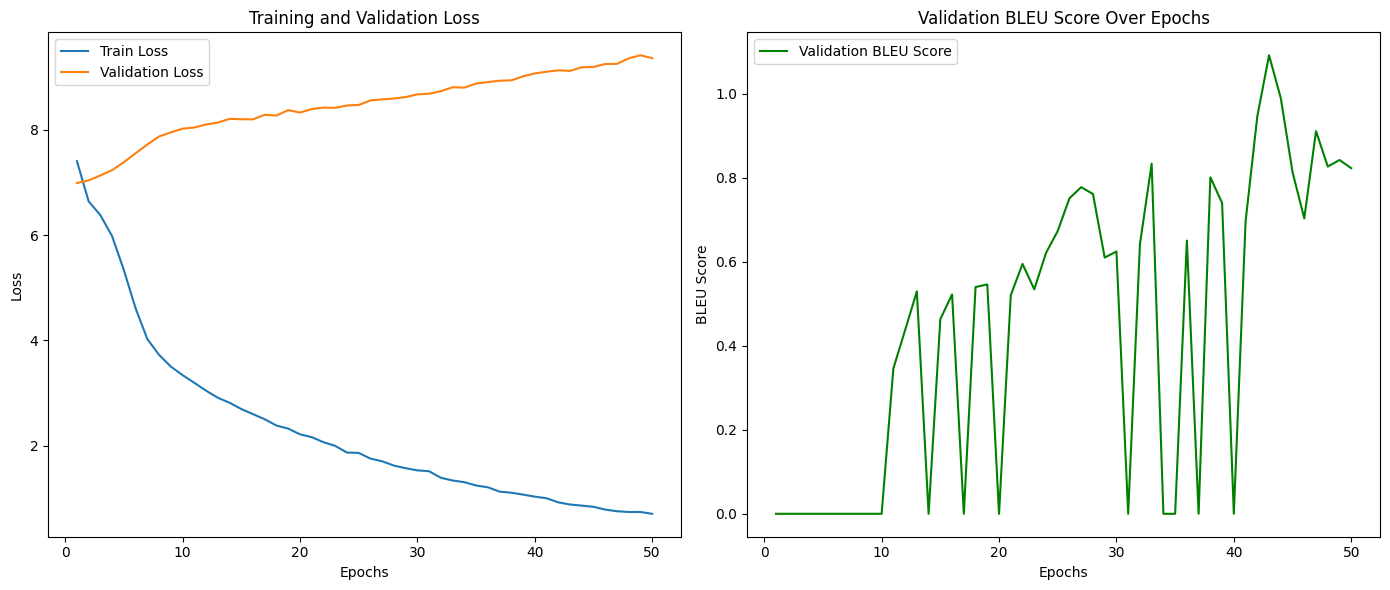

In [10]:
# Plot training and validation loss, and BLEU scores
plot_results(train_losses, val_losses, val_bleu_scores)


# **Evaluate the Model on the Test Set**

In [ ]:
# Evaluate on the test set
test_references, test_translations = generate_translations_collect(model, test_loader, english_idx2word)
test_bleu = compute_bleu_score([ref.split() for ref in test_references], [hyp.split() for hyp in test_translations])

# Also, compute BLEU score on validation set
# Note: During training, val_bleu_scores already contains BLEU scores per epoch. We'll take the last one.
final_val_bleu = val_bleu_scores[-1]
final_val_loss = val_losses[-1]

# Compute test loss
model.eval()
test_loss = 0

with torch.no_grad():
    for input_seq, target_seq in test_loader:
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)

        output = model(input_seq, target_seq, teacher_forcing_ratio=0)  

        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        target = target_seq[:, 1:].reshape(-1)

        loss = criterion(output, target)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)

# Create a comparative results table
results_table = create_results_table(
    train_losses, val_losses, val_bleu_scores, avg_test_loss, test_bleu
)
print("\nComparative Results:")
print(results_table)


# **Added: Save predictions.txt and references.txt**
with open('predictions.txt', 'w', encoding='utf-8') as f_pred, open('references.txt', 'w', encoding='utf-8') as f_ref:
    for ref, hyp in zip(test_references, test_translations):
        f_ref.write(ref + '\n')
        f_pred.write(hyp + '\n')

print(f"Test BLEU Score: {test_bleu:.2f}")
print("\nPredictions have been saved to 'predictions.txt'.")
print("References have been saved to 'references.txt'.")

# Optionally, save sample translations to a file
with open('sample_translations.txt', 'w', encoding='utf-8') as f:
    for i in range(min(5, len(test_urdu))):
        # Decode source sentence
        source_tokens = [urdu_idx2word.get(idx, '<unk>') for idx in test_urdu[i] if idx not in [urdu_word2idx['<pad>'], urdu_word2idx['<sos>'], urdu_word2idx['<eos>']]]
        source_sentence = ' '.join(source_tokens)

        # Reference and prediction
        reference = test_references[i]
        prediction = test_translations[i]

        f.write(f"Source: {source_sentence}\n")
        f.write(f"Reference: {reference}\n")
        f.write(f"Prediction: {prediction}\n")
        f.write("-" * 50 + "\n")

print("\nSample translations have been saved to 'sample_translations.txt'.")
print("Comparative results have been saved to 'comparative_results.csv'.")


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)



Comparative Results:
       Metric Training Set  Validation Set       Test Set
0        Loss     0.711011        9.356374   9.415205e+00
1  BLEU Score            -        0.823272  9.853390e-230
Test BLEU Score: 0.00

Predictions have been saved to 'predictions.txt'.
References have been saved to 'references.txt'.

Sample translations have been saved to 'sample_translations.txt'.
Comparative results have been saved to 'comparative_results.csv'.


# **Save Comparative Results to CSV**

In [12]:
# Save the table to a CSV file
results_table.to_csv('comparative_results.csv', index=False)
print("Comparative results have been saved to 'comparative_results.csv'.")


Comparative results have been saved to 'comparative_results.csv'.


**perl multi-bleu.perl references.txt < predictions.txt**


BLEU = 58.73, 24.6/2.4/0.1/0.0 (BP=0.960, ratio=0.961, hyp_len=6848, ref_len=7129)
It is not advisable to publish scores from multi-bleu.perl.  

